In [1]:
import cplex
import pandas as pd
import itertools

### Parameters

In [2]:
vertex_set, subsets = set(), {}

In [3]:
# class to create vertices as objects
class vertex:
    def __init__(self, id, index):
        self.id = id
        self.index = index
        self.distance = {} #dict distances between other vertices
    
    def __str__(self):
        return self.id

We need a function or functions to generate vertex objects, set the distances and find all of the subsets needed in constraints

In [4]:
def create_distances(dist_matrix):
    
    global vertex_set, subsets #Global variables can be used by everyone, both inside of functions and outside
    
    for i in range(len(dist_matrix)):
        vertex_set.add(vertex(id = 'v_' + str(i) , index = i)) #create al the vertices using the matrix of distances
        
    for i in vertex_set:
        for j in vertex_set:
            if j is not i :
                i.distance[j] = dist_matrix[i.index][j.index] #fill the dict distances of each vertex
                
    for n in range(2, len(vertex_set)):
        subsets[n] = set(itertools.combinations(vertex_set,n))  #itertools.combinations(iterable, r-length)
                                                                #return r-length tuples in sorted order with no repeated elements

creation of vertices

In [5]:
distances = pd.read_excel('TSP_input.xlsx',index_col=0)
dist_matrix = distances.values.tolist()
create_distances(dist_matrix)

### Objective Function 

In [6]:
cpx=cplex.Cplex()
cpx.objective.set_sense(cpx.objective.sense.minimize)

### Decision Variables

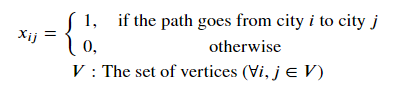

In [7]:
x = { i : { j : 'x_' + str(i) + '_' + str(j) for j in range(len(vertex_set))} for i in range(len(vertex_set))}

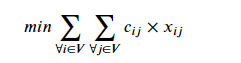 

In [8]:
for i in vertex_set:
    for j in vertex_set:
        if j.index != i.index: # to avoid the double entry error
            cpx.variables.add(obj=[i.distance[j]], types = ['B'], names = [x[i.index][j.index]])

### Constraints 

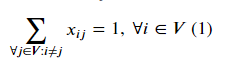

In [9]:
for i in vertex_set:
    coef_1, var_1 = [], []
    for j in vertex_set:
        if j.index != i.index:
            coef_1.append(1)
            var_1.append(x[i.index][j.index])
    cpx.linear_constraints.add(lin_expr = [[var_1, coef_1]], senses = ['E'], rhs = [1])

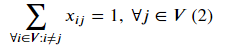

In [10]:
for j in vertex_set:
    coef_2, var_2 = [], []
    for i in vertex_set:
        if j.index != i.index:
            coef_2.append(1)
            var_2.append(x[i.index][j.index])
    cpx.linear_constraints.add(lin_expr = [[var_2, coef_2]], senses = ['E'], rhs = [1]) 

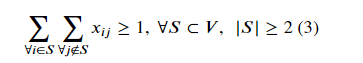

In [11]:
for l in range(2,len(vertex_set)):
    for s in subsets[l]:
        var_3 = []
        coef_3 = []
        for i in s:
            for j in vertex_set:
                if j.index != i.index:
                    set_j = set()
                    set_j.add(j)
                    z = set_j.issubset(s) # if vertex j is an element of subset s, z = True
                    if z is False: #if j is not an element of subset s, add the decision variable
                        var_3.append(x[i.index][j.index])
                        coef_3.append(1)
        cpx.linear_constraints.add(lin_expr=[[var_3, coef_3]], senses=["G"], rhs=[1]) 

### Solve

In [12]:
cpx.solve()
print()
print("Solution status = ", cpx.solution.get_status(), ":", end=' ')
print(cpx.solution.status[cpx.solution.get_status()])
print("Solution value  = ", cpx.solution.get_objective_value())
print()

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 13 rows and 0 columns.
Reduced MIP has 8190 rows, 156 columns, and 319488 nonzeros.
Reduced MIP has 156 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.23 sec. (118.55 ticks)
Probing time = 0.02 sec. (3.28 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 8190 rows, 156 columns, and 319488 nonzeros.
Reduced MIP has 156 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.16 sec. (128.64 ticks)
Probing time = 0.02 sec. (3.88 ticks)
Clique table members: 26.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.17 sec. (48.10 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Ga

In [15]:
solution = []
for i in vertex_set:
	for j in vertex_set:
		if j.index != i.index:
			if cpx.solution.get_values(x[i.index][j.index]) > 0:
				new_edge = [i.index, j.index]
				solution.append(new_edge)
                
solution

[[9, 0],
 [5, 9],
 [12, 6],
 [0, 7],
 [10, 5],
 [1, 11],
 [6, 8],
 [8, 1],
 [11, 10],
 [7, 2],
 [2, 3],
 [4, 12],
 [3, 4]]

Print Solution 

In [16]:
TSP_route = []
TSP_route.append(solution[0]) # start from the first edge in the solution
to_go = TSP_route[0][1] #second vertix
a = 0

while a < len(solution) - 1:
    for b in range(1, len(solution)):
        if solution[b][0] == to_go:
            TSP_route.append(solution[b])
            to_go = solution[b][1]
    a += 1
    
print()
print(TSP_route)
print("Optimal route:")
for i in range(len(TSP_route) - 1):
    print(str(TSP_route[i][1] + 1) + " -->", end=' ')
print(str(TSP_route[-1][1] + 1) + " --> " + str(TSP_route[0][1] + 1))


[[9, 0], [0, 7], [7, 2], [2, 3], [3, 4], [4, 12], [12, 6], [6, 8], [8, 1], [1, 11], [11, 10], [10, 5], [5, 9]]
Optimal route:
1 --> 8 --> 3 --> 4 --> 5 --> 13 --> 7 --> 9 --> 2 --> 12 --> 11 --> 6 --> 10 --> 1
